In [1]:
# ── install & import ──────────────────────────────────────────
!pip -q install opencv-python pillow matplotlib numpy

import cv2, numpy as np, matplotlib.pyplot as plt, json, textwrap, datetime
from pathlib import Path
from PIL import Image
print("✔️  Libraries ready")

✔️  Libraries ready


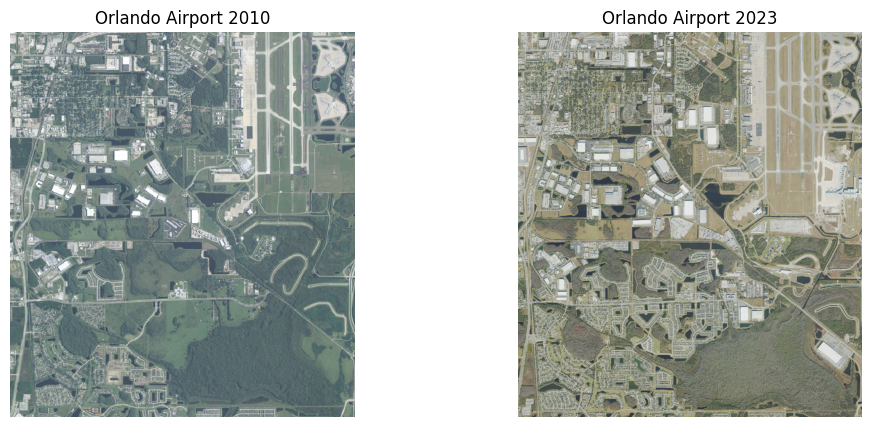

In [2]:
# ── put both images in the notebook folder ──
img_2010 = cv2.cvtColor(cv2.imread('orlando2010.png'), cv2.COLOR_BGR2RGB)
img_2023 = cv2.cvtColor(cv2.imread('orlando2023.png'), cv2.COLOR_BGR2RGB)

assert img_2010 is not None and img_2023 is not None, "Images not found"

# side-by-side preview
plt.figure(figsize=(12,5))
for i,(im,yr) in enumerate([(img_2010,'2010'),(img_2023,'2023')],1):
    plt.subplot(1,2,i); plt.imshow(im); plt.title(f"Orlando Airport {yr}")
    plt.axis('off')
plt.show()

In [3]:
def detect_buildings(img):
    """
    crude building mask: light-grey rectangles ≈ terminals / hangars / parking decks
    tweak thresholds per imagery
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # light-grey range
    lower, upper = np.array([0, 0, 120]), np.array([180, 40, 255])
    mask = cv2.inRange(hsv, lower, upper)
    # morphological clean-up
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def detect_roads(img):
    """
    roads / taxiways ≈ dark asphalt
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = cv2.inRange(gray, 0, 70)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return mask

# generate masks
b_2010, b_2023 = detect_buildings(img_2010), detect_buildings(img_2023)
r_2010, r_2023 = detect_roads(img_2010),     detect_roads(img_2023)

In [6]:
if b_2010.shape != b_2023.shape:
    b_2010 = cv2.resize(b_2010, (b_2023.shape[1], b_2023.shape[0]))
print("b_2010:", b_2010.shape, b_2010.dtype)
print("b_2023:", b_2023.shape, b_2023.dtype)


b_2010: (1024, 913) uint8
b_2023: (1024, 913) uint8


b_2010: (1024, 913) uint8
b_2023: (1024, 913) uint8


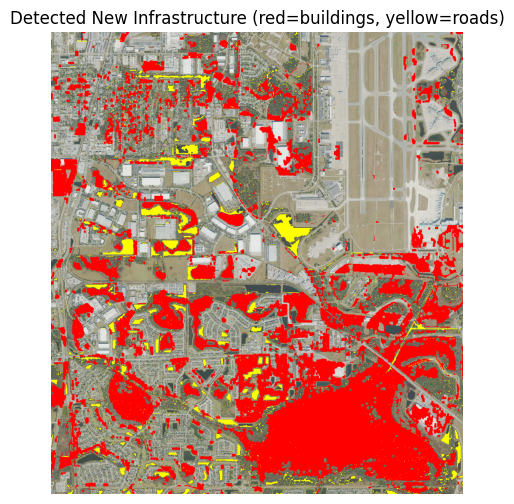

In [8]:

def area_pct(mask):
    return 100 * mask.sum() / mask.size

def change_stats(m2010, m2023, label):
    pct10 = area_pct(m2010)
    pct23 = area_pct(m2023)
    return {
        f'{label}_2010_%': pct10,
        f'{label}_2023_%': pct23,
        f'{label}_change_%': pct23 - pct10
    }

def preprocess_mask(mask, target_shape):
    # Convert to grayscale if RGB
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Resize if needed
    if mask.shape != target_shape:
        mask = cv2.resize(mask, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Ensure mask is binary uint8 (0 or 1)
    mask = mask.astype(np.uint8)
    mask[mask > 0] = 1

    return mask

# === Set reference shape ===
target_shape = b_2023.shape[:2]

# === Preprocess masks ===
b_2010 = preprocess_mask(b_2010, target_shape)
b_2023 = preprocess_mask(b_2023, target_shape)
r_2010 = preprocess_mask(r_2010, target_shape)
r_2023 = preprocess_mask(r_2023, target_shape)

# === Double-check debugging info ===
print("b_2010:", b_2010.shape, b_2010.dtype)
print("b_2023:", b_2023.shape, b_2023.dtype)

# === Calculate stats ===
stats = {}
stats.update(change_stats(b_2010, b_2023, 'buildings'))
stats.update(change_stats(r_2010, r_2023, 'roads'))

# === Bitwise new infrastructure detection ===
try:
    new_b = cv2.bitwise_and(b_2023, cv2.bitwise_not(b_2010))
    new_r = cv2.bitwise_and(r_2023, cv2.bitwise_not(r_2010))
except cv2.error as e:
    print("Bitwise operation failed:", e)
    print("Shapes -> b_2010:", b_2010.shape, ", b_2023:", b_2023.shape)
    print("Dtypes -> b_2010:", b_2010.dtype, ", b_2023:", b_2023.dtype)
    raise

# === Create overlay ===
overlay = img_2023.copy()
if overlay.dtype != np.uint8:
    overlay = (overlay * 255).astype(np.uint8)

# Ensure overlay is 3-channel
if len(overlay.shape) == 2:
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)

# Color new infrastructure
overlay[new_b > 0] = [255, 0, 0]      # Red for new buildings
overlay[new_r > 0] = [255, 255, 0]    # Yellow for new roads

# === Show output ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Detected New Infrastructure (red=buildings, yellow=roads)")
plt.show()

In [18]:
import datetime
import textwrap
from pathlib import Path

def make_report(stat_dict):
    bullets = []
    # buildings
    bchg = stat_dict['buildings_change_%']
    if abs(bchg) > 0.1:
        direction = "increase" if bchg > 0 else "decrease"
        bullets.append(f"Built-up area shows a {abs(bchg):.1f}% {direction} (from "
                       f"{stat_dict['buildings_2010_%']:.1f}% to {stat_dict['buildings_2023_%']:.1f}%).")
    # roads
    rchg = stat_dict['roads_change_%']
    if abs(rchg) > 0.1:
        direction = "increase" if rchg > 0 else "decrease"
        bullets.append(f"Paved road/taxiway coverage exhibits a {abs(rchg):.1f}% {direction} "
                       f"(from {stat_dict['roads_2010_%']:.1f}% to {stat_dict['roads_2023_%']:.1f}%).")
    # craft summary
    summary = "Significant infrastructure expansion detected." if (bchg > 2 or rchg > 2) else \
              "Moderate changes observed."
    date = datetime.date.today().isoformat()
    bullet_text = '\n- '.join(bullets)  # <-- moved this line out of f-string

    report = f"""
    ORLANDO AIRPORT INFRASTRUCTURE CHANGE REPORT
    Generated {date}

    Executive Summary
    -----------------
    {summary}

    Detailed Findings
    -----------------
    -{bullet_text}

    Methodology
    -----------
    Simple pixel-based colour segmentation for buildings (light-grey) and roads/taxiways (dark).
    Change mask derived by differencing 2010 and 2023 binary masks.
    Percentages represent share of full image footprint.

    Limitations
    -----------
    Heuristic detection; fine objects and subtle colour variations may be missed.
    Consider replacing detectors with CNN (e.g. U-Net) for production accuracy.
    """
    return textwrap.dedent(report)

final_report = make_report(stats)
print(final_report)

# optional: save
Path("orlando_change_report.txt").write_text(final_report)
print("✔️  Report saved to orlando_change_report.txt")


    ORLANDO AIRPORT INFRASTRUCTURE CHANGE REPORT
    Generated 2025-08-06

    Executive Summary
    -----------------
    Significant infrastructure expansion detected.

    Detailed Findings
    -----------------
    -Built-up area shows a 2.2% increase (from 63.4% to 65.6%).
- Paved road/taxiway coverage exhibits a 3.1% increase (from 0.0% to 3.1%).

    Methodology
    -----------
    Simple pixel-based colour segmentation for buildings (light-grey) and roads/taxiways (dark).
    Change mask derived by differencing 2010 and 2023 binary masks.
    Percentages represent share of full image footprint.

    Limitations
    -----------
    Heuristic detection; fine objects and subtle colour variations may be missed.
    Consider replacing detectors with CNN (e.g. U-Net) for production accuracy.

✔️  Report saved to orlando_change_report.txt
